In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal
from data_subplot import data_subplot

from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals

%matplotlib inline

In [3]:


# SYNC
def build_bcg_df(bcg_values, initial_timestamp, fs):
    """
    Constructs a BCG DataFrame from raw values, initial timestamp, and sampling rate.
    
    Args:
        bcg_values: List of BCG signal values (e.g., [-86, -90, -91, -86])
        initial_timestamp: Timestamp of first sample (epoch ms or datetime string)
        fs: Sampling frequency in Hz
        
    Returns:
        pd.DataFrame with columns: ['Timestamp', 'BCG', 'Time']
    """
    # Convert timestamp to datetime if it's a string
    if isinstance(initial_timestamp, str):
        initial_timestamp = pd.to_datetime(initial_timestamp)
    elif isinstance(initial_timestamp, (int, float)):
        initial_timestamp = pd.to_datetime(initial_timestamp, unit='ms')
    
    # Calculate time intervals
    period = 1 / fs
    timestamps = [initial_timestamp + pd.Timedelta(seconds=i*period) 
                 for i in range(len(bcg_values))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'BCG': bcg_values
    })
    
    # Add human-readable time
    df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S.%f')
    
    return df




def synchronize_bcg_and_hr(df_bcg_raw, df_hr_raw):
    """
    Builds and synchronizes BCG and HR DataFrames starting from the first common time.
    
    Args:
        df_bcg_raw: Raw BCG DataFrame from CSV. Must contain 'BCG', 'Timestamp', and 'fs' columns.
        df_hr_raw: Raw HR DataFrame from CSV. Must contain 'Timestamp' column in datetime-compatible format.
    
    Returns:
        bcg_aligned, hr_aligned: Time-synchronized DataFrames
    """
        # Parse BCG values and metadata
    bcg_values = df_bcg_raw['BCG'].tolist()
    initial_timestamp = pd.to_datetime(df_bcg_raw.loc[0, 'Timestamp'], unit='ms')
    fs = float(df_bcg_raw.loc[0, 'fs'])

    # Build BCG DataFrame
    df_bcg = build_bcg_df(bcg_values, initial_timestamp, fs)

    # Parse HR timestamps
    df_hr_raw['Timestamp'] = pd.to_datetime(df_hr_raw['Timestamp'])

    # Find common time range
    start_time = max(df_bcg['Timestamp'].min(), df_hr_raw['Timestamp'].min())
    end_time = min(df_bcg['Timestamp'].max(), df_hr_raw['Timestamp'].max())

    # Trim both DataFrames to common range
    bcg_aligned = df_bcg[(df_bcg['Timestamp'] >= start_time) & (df_bcg['Timestamp'] <= end_time)].copy()
    hr_aligned = df_hr_raw[(df_hr_raw['Timestamp'] >= start_time) & (df_hr_raw['Timestamp'] <= end_time)].copy()

    # Reset index
    bcg_aligned.reset_index(drop=True, inplace=True)
    hr_aligned.reset_index(drop=True, inplace=True)

    return bcg_aligned, hr_aligned






In [4]:

#read csv files
df_bcg= pd.read_csv('/home/bahey/bio_data/dataset/data/01/BCG/01_20231105_BCG.csv')        #### n4 &
df_heart=pd.read_csv("/home/bahey/bio_data/dataset/data/01/Reference/RR/01_20231105_RR.csv")   #### 1 second one

# step 1 :Synchronize BCG and HR DataFrames from the first common time
bcg_sync, hr_sync = synchronize_bcg_and_hr(df_bcg, df_heart)

print("Time synchronized BCG DataFrame:")
print(bcg_sync.head())
print("\nTime synchronized Heart Rate DataFrame:")
print(hr_sync.head())


Time synchronized BCG DataFrame:
                      Timestamp  BCG             Time
0 2023-11-04 19:12:20.003285714  -60  19:12:20.003285
1 2023-11-04 19:12:20.010428571  -65  19:12:20.010428
2 2023-11-04 19:12:20.017571428 -101  19:12:20.017571
3 2023-11-04 19:12:20.024714285  -59  19:12:20.024714
4 2023-11-04 19:12:20.031857142  -15  19:12:20.031857

Time synchronized Heart Rate DataFrame:
            Timestamp  Heart Rate  RR Interval in seconds
0 2023-11-04 19:12:20          99                   0.613
1 2023-11-04 19:12:20          99                   0.621
2 2023-11-04 19:12:21          98                   0.626
3 2023-11-04 19:12:22          98                   0.632
4 2023-11-04 19:12:22          98                   0.635


In [5]:
hr_sync['Timestamp'] = pd.to_datetime(hr_sync['Timestamp'])

# Set Timestamp as the index
hr_sync.set_index('Timestamp', inplace=True)

# Group by 10-second windows and compute both mean and count
windowed_df = hr_sync.resample('10S').agg({
    'Heart Rate': ['mean', 'count']
})

# Optional: flatten MultiIndex columns
windowed_df.columns = ['HR_mean', 'HR_count']

# Print the result
print(windowed_df)


                        HR_mean  HR_count
Timestamp                                
2023-11-04 19:12:20   98.687500        16
2023-11-04 19:12:30  100.625000        16
2023-11-04 19:12:40   94.066667        15
2023-11-04 19:12:50   92.625000        16
2023-11-04 19:13:00   92.000000        12
...                         ...       ...
2023-11-04 22:05:10   59.300000        10
2023-11-04 22:05:20   60.300000        10
2023-11-04 22:05:30   60.100000        10
2023-11-04 22:05:40   59.800000        10
2023-11-04 22:05:50   59.500000         2

[1042 rows x 2 columns]


/tmp/ipykernel_31248/2681601418.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  windowed_df = hr_sync.resample('10S').agg({


In [6]:
# resample bcg to 50 hz 
bcg_sync.set_index('Timestamp', inplace=True)

# Original sampling rate (140 Hz)
fs_original = 140  
# Target sampling rate (50 Hz)
fs_target = 50  

# Calculate resampling factor
resample_factor = fs_target / fs_original

# Number of samples in resampled signal
num_samples = int(len(bcg_sync) * resample_factor)

# Resample the BCG signal using Fourier method (preserves timing information)
resampled_bcg = signal.resample(bcg_sync['BCG'], num_samples)

# Create new timestamps for the resampled data
start_time = bcg_sync.index[0]
end_time = bcg_sync.index[-1]
new_timestamps = pd.date_range(start=start_time, end=end_time, periods=num_samples)

# Create new DataFrame with resampled data
resampled_df = pd.DataFrame({
    'BCG': resampled_bcg,
    'Time': new_timestamps.time
}, index=new_timestamps)

# Reset index if you want Timestamp as a column again
resampled_df.reset_index(inplace=True)
resampled_df.rename(columns={'index': 'Timestamp'}, inplace=True)

print(resampled_df.head())

                      Timestamp         BCG             Time
0 2023-11-04 19:12:20.003285714  -62.199690  19:12:20.003285
1 2023-11-04 19:12:20.023285755  -51.919848  19:12:20.023285
2 2023-11-04 19:12:20.043285796 -125.002844  19:12:20.043285
3 2023-11-04 19:12:20.063285837 -811.109988  19:12:20.063285
4 2023-11-04 19:12:20.083285878 -414.326722  19:12:20.083285


In [7]:
total =len(resampled_df)/500
total = int(total)
print(total)

1041


Data stream length: 520581


/tmp/ipykernel_31248/598734467.py:3: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds


Bad windows: [  67   68  136  137  142  143  144  223  225  227  228  281  282  283
  303  306  307  344  417  442  443  452  453  454  547  548  549  555
  563  599  600  632  743  823  828  830  831  832  925  931  939  941
  945  946  950  958  959  960  962  966  973  974  975  979  993 1011
 1015 1021 1022 1024 1028 1030 1034 1035 1036 1037 1039 1040]


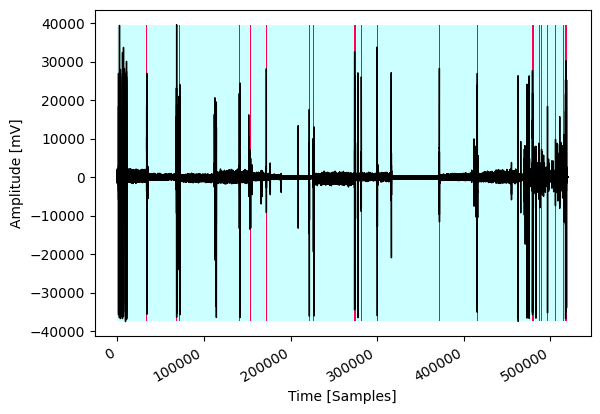

In [8]:
bcg = resampled_df
start_point, end_point, window_shift, fs = 0, 500, 500, 50
bcg['epoch'] = bcg['Timestamp'].view('int64') // 10**6 # convert to milliseconds
utc_time = bcg['epoch']
data_stream = bcg['BCG']
print("Data stream length:", len(data_stream))
data_stream, utc_time, bad_windows  = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)
print("Bad windows:", bad_windows)

Wavelet Cycle Length: 520512


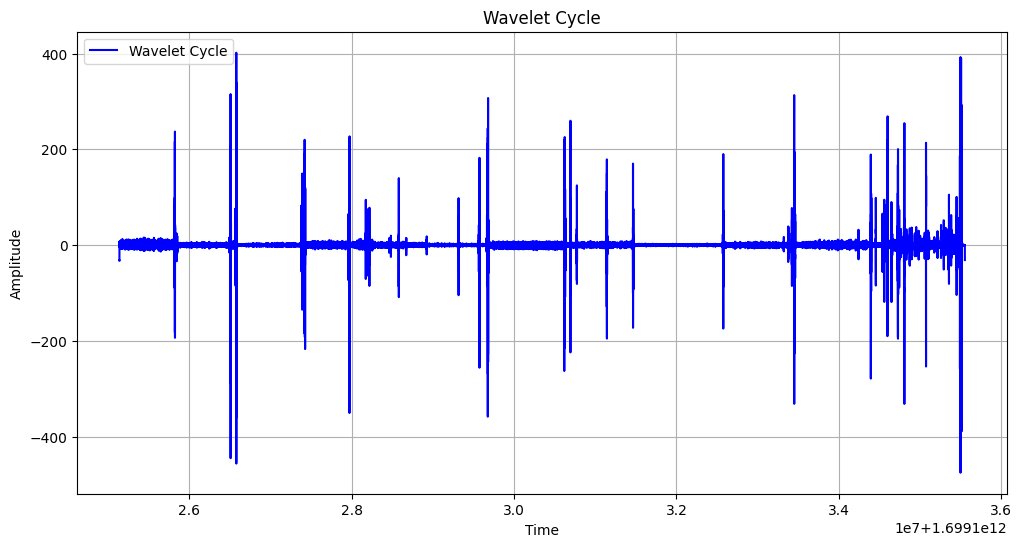

In [9]:
movement = band_pass_filtering(data_stream, fs, "bcg")
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]
print("Wavelet Cycle Length:", len(wavelet_cycle))
# plot the wavelet cycle
plt.figure(figsize=(12, 6))
plt.plot(utc_time, wavelet_cycle, label='Wavelet Cycle', color='blue')
plt.title('Wavelet Cycle')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [10]:
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time.values, mpd=1, plot=0)  # utc_time.values in seconds 


In [11]:
print('Minimum pulse : ', np.around(np.min(beats)))
print('Maximum pulse : ', np.around(np.max(beats)))
print('Average pulse : ', np.around(np.mean(beats)))
print('length of pulse : ', int(len(beats)))

Minimum pulse :  64.0
Maximum pulse :  106.0
Average pulse :  85.0
length of pulse :  1041


In [12]:
hr_sync.index 

DatetimeIndex(['2023-11-04 19:12:20', '2023-11-04 19:12:20',
               '2023-11-04 19:12:21', '2023-11-04 19:12:22',
               '2023-11-04 19:12:22', '2023-11-04 19:12:23',
               '2023-11-04 19:12:24', '2023-11-04 19:12:25',
               '2023-11-04 19:12:25', '2023-11-04 19:12:26',
               ...
               '2023-11-04 22:05:42', '2023-11-04 22:05:43',
               '2023-11-04 22:05:44', '2023-11-04 22:05:45',
               '2023-11-04 22:05:46', '2023-11-04 22:05:47',
               '2023-11-04 22:05:48', '2023-11-04 22:05:49',
               '2023-11-04 22:05:50', '2023-11-04 22:05:51'],
              dtype='datetime64[ns]', name='Timestamp', length=12617, freq=None)

In [13]:
hr_sync.index = pd.to_datetime(hr_sync.index)

# Resample into non-overlapping 10-second windows and compute mean HR
mean_hr_df = hr_sync.resample('10S').mean(numeric_only=True).dropna().reset_index()

# Select and rename columns
mean_hr_df = mean_hr_df[['Timestamp', 'Heart Rate']].rename(
    columns={'Timestamp': 'Window Start', 'Heart Rate': 'Mean HR'}
)
mean_hr_df

/tmp/ipykernel_31248/3326357812.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  mean_hr_df = hr_sync.resample('10S').mean(numeric_only=True).dropna().reset_index()


,Window Start,Mean HR
0,2023-11-04 19:12:20,98.687500
1,2023-11-04 19:12:30,100.625000
2,2023-11-04 19:12:40,94.066667
3,2023-11-04 19:12:50,92.625000
4,2023-11-04 19:13:00,92.000000
...,...,...
1035,2023-11-04 22:05:10,59.300000
1036,2023-11-04 22:05:20,60.300000
1037,2023-11-04 22:05:30,60.100000
1038,2023-11-04 22:05:40,59.800000


In [14]:
filtered_array = np.delete(beats, bad_windows, axis=0)
len(filtered_array)

973

In [15]:
# drop from beats and mean_hr_df the indices in bad windows
existing_bad_windows = [idx for idx in bad_windows if idx in mean_hr_df.index]
filtered_df = mean_hr_df.drop(index=existing_bad_windows)
# same number of windows

In [16]:
# error calculation
y_true = filtered_df['Mean HR'].values
y_pred = filtered_array
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_true - y_pred))

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Mean Absolute Percentage Error (MAPE)
# Add small epsilon to avoid division by zero
epsilon = 1e-10
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")


MAE: 10.872
RMSE: 13.068
MAPE: 14.57%
